<a href="https://colab.research.google.com/github/movindugunarathna/sinXdetect/blob/main/ml/sinbert_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SinBERT Text Classifier for Sinhala AI Detection

This notebook implements a text classification model using NLPC-UOM's SinBERT-large model to detect AI-generated Sinhala text. SinBERT is specifically trained on Sinhala language data, making it potentially more effective for Sinhala text classification tasks compared to multilingual models.

## 1. Install Required Libraries

In [1]:
%pip install -q tf-keras
%pip install -q transformers
%pip install -q datasets
%pip install -q nltk
%pip install -q scikit-learn
%pip install -q matplotlib
%pip install -q seaborn

## 2. Import Required Libraries

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    f1_score
)
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    AutoConfig
)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Load Dataset from JSONL Files

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

def load_jsonl(filepath):
    """Load data from JSONL file"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

# Define the path to the dataset in Google Drive
# Update this path based on where you stored the 'dataset' folder in your Drive
drive_base_path = '/content/drive/MyDrive/Colab Notebooks/sinxdetect/dataset'

# Load training, validation, and test datasets
train_data = load_jsonl(os.path.join(drive_base_path, 'train.jsonl'))
val_data = load_jsonl(os.path.join(drive_base_path, 'val.jsonl'))
test_data = load_jsonl(os.path.join(drive_base_path, 'test.jsonl'))

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")

Mounted at /content/drive
Training set size: 77788
Validation set size: 9045
Testing set size: 13046


## 4. Convert to DataFrame and Explore Data

In [4]:
# Convert to DataFrame
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# Display sample data
print("Sample training data:")
print(train_df[['text', 'label']].head())
print(f"\nLabel distribution (Train):")
print(train_df['label'].value_counts())
print(f"\nLabel distribution (Validation):")
print(val_df['label'].value_counts())
print(f"\nLabel distribution (Test):")
print(test_df['label'].value_counts())

Sample training data:
                                                text  label
0  ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය ...     AI
1  ශ්‍රී ලංකා රජය දෙමළ සංවිධාන හයකට පනවා තිබූ තහන...     AI
2  (අමදෝරු අමරජීව) රාජ්‍ය සේවා තරග විභාගයකදී වංචා...  HUMAN
3  (ප්‍රින්ස් රත්නායක)ශ්‍රී ලංකා සබරගමුව විශ්වවිද...  HUMAN
4  (ඩී.ජී.සුගතපාල)දඩල්ල මුහුදු වෙරලට පැමිණෙන පෙම්...  HUMAN

Label distribution (Train):
label
HUMAN    39848
AI       37940
Name: count, dtype: int64

Label distribution (Validation):
label
HUMAN    4981
AI       4064
Name: count, dtype: int64

Label distribution (Test):
label
HUMAN    6981
AI       6065
Name: count, dtype: int64


## 5. Map Labels to Numeric Values

In [5]:
# Create label mapping
label_mapping = {'HUMAN': 0, 'AI': 1}
reverse_mapping = {v: k for k, v in label_mapping.items()}

# Map labels to numeric values
train_df['label_encoded'] = train_df['label'].map(label_mapping)
val_df['label_encoded'] = val_df['label'].map(label_mapping)
test_df['label_encoded'] = test_df['label'].map(label_mapping)

# Check for any unmapped values
print(f"Train - Unmapped labels: {train_df['label_encoded'].isna().sum()}")
print(f"Val - Unmapped labels: {val_df['label_encoded'].isna().sum()}")
print(f"Test - Unmapped labels: {test_df['label_encoded'].isna().sum()}")

Train - Unmapped labels: 0
Val - Unmapped labels: 0
Test - Unmapped labels: 0


## 6. Sinhala Text Preprocessing

**Important Note:** SinBERT was trained specifically on Sinhala text and its tokenizer is designed to handle Sinhala linguistic variations. We apply minimal preprocessing to preserve the natural text patterns that SinBERT was trained on. This is different from multilingual models that may benefit from more aggressive normalization.

Based on the word cloud analysis, common Sinhala words in the dataset include: මම, ඔබ, කළ, වන, සිංහල, කරන, etc. We preserve these natural forms.

In [6]:
def preprocess_sinhala_text(text):
    """
    Minimal Sinhala text preprocessing optimized for SinBERT:
    - NFC Unicode normalization (essential for consistency)
    - Clean extra whitespace
    - Preserve natural Sinhala variations (SinBERT's tokenizer handles these)

    Note: We avoid aggressive normalization (contractions, zero-width chars, etc.)
    because SinBERT was trained on natural Sinhala text with these variations.
    Removing them may hurt performance.
    """
    if not isinstance(text, str):
        return text

    # Normalize to NFC (Canonical Composition) - Essential for Unicode consistency
    text = unicodedata.normalize('NFC', text)

    # Clean extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove any unusual control characters (but keep common Sinhala ones)
    # Keep ZWNJ (U+200C) and ZWJ (U+200D) as they're part of proper Sinhala orthography
    text = re.sub(r'[\x00-\x08\x0B-\x0C\x0E-\x1F\x7F-\x9F]', '', text)

    return text

# Apply preprocessing
print("Preprocessing training data...")
train_df['processed_text'] = train_df['text'].apply(preprocess_sinhala_text)

print("Preprocessing validation data...")
val_df['processed_text'] = val_df['text'].apply(preprocess_sinhala_text)

print("Preprocessing test data...")
test_df['processed_text'] = test_df['text'].apply(preprocess_sinhala_text)

print("\nPreprocessing complete!")
print(f"\nExample preprocessed text:")
print(f"Original: {train_df['text'].iloc[0][:100]}...")
print(f"Processed: {train_df['processed_text'].iloc[0][:100]}...")

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...

Preprocessing complete!

Example preprocessed text:
Original: ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය සංග්‍රහය ඉක්මනින්ම රසිකයන් හමුවට පැමිණෙන බව වාර්තා වේ....
Processed: ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය සංග්‍රහය ඉක්මනින්ම රසිකයන් හමුවට පැමිණෙන බව වාර්තා වේ....


## 7. Load SinBERT Tokenizer

Using `NLPC-UOM/SinBERT-large` which is specifically trained on Sinhala language data. This model should provide better performance for Sinhala text classification compared to multilingual models.

{BERTifying Sinhala - A Comprehensive Analysis of Pre-trained Language Models for Sinhala Text Classification, LREC 2022}

In [ ]:
# Load SinBERT tokenizer
MODEL_NAME = 'NLPC-UOM/SinBERT-large'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"✓ SinBERT tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Max length: {tokenizer.model_max_length}")

config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

✓ SinBERT tokenizer loaded: NLPC-UOM/SinBERT-large
Vocabulary size: 52000
Max length: 1000000000000000019884624838656


## 8. Tokenize and Encode Text Data

In [8]:
# Configuration
MAX_LENGTH = 256  # Optimal for most Sinhala text
BATCH_SIZE = 32

def tokenize_in_batches(texts, tokenizer, batch_size=32, max_length=256):
    """
    Tokenize texts in batches to manage memory efficiently.
    Returns dict with 'input_ids' and 'attention_mask' as numpy arrays.
    """
    input_ids_parts = []
    attention_mask_parts = []

    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # Tokenize batch
        enc = tokenizer(
            batch,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )

        # Convert to numpy
        ids = enc['input_ids'].numpy()
        mask = enc['attention_mask'].numpy()

        input_ids_parts.append(ids)
        attention_mask_parts.append(mask)

        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {i // batch_size + 1}/{total_batches} batches")

    # Concatenate all batches
    input_ids = np.concatenate(input_ids_parts, axis=0)
    attention_mask = np.concatenate(attention_mask_parts, axis=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask}

# Tokenize datasets
print("Tokenizing training data...")
train_encodings = tokenize_in_batches(
    train_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\nTokenizing validation data...")
val_encodings = tokenize_in_batches(
    val_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\nTokenizing test data...")
test_encodings = tokenize_in_batches(
    test_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\n✓ Tokenization complete!")
print(f"Training encodings shape: {train_encodings['input_ids'].shape}")
print(f"Validation encodings shape: {val_encodings['input_ids'].shape}")
print(f"Test encodings shape: {test_encodings['input_ids'].shape}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizing training data...
  Processed 10/2431 batches
  Processed 20/2431 batches
  Processed 30/2431 batches
  Processed 40/2431 batches
  Processed 50/2431 batches
  Processed 60/2431 batches
  Processed 70/2431 batches
  Processed 80/2431 batches
  Processed 90/2431 batches
  Processed 100/2431 batches
  Processed 110/2431 batches
  Processed 120/2431 batches
  Processed 130/2431 batches
  Processed 140/2431 batches
  Processed 150/2431 batches
  Processed 160/2431 batches
  Processed 170/2431 batches
  Processed 180/2431 batches
  Processed 190/2431 batches
  Processed 200/2431 batches
  Processed 210/2431 batches
  Processed 220/2431 batches
  Processed 230/2431 batches
  Processed 240/2431 batches
  Processed 250/2431 batches
  Processed 260/2431 batches
  Processed 270/2431 batches
  Processed 280/2431 batches
  Processed 290/2431 batches
  Processed 300/2431 batches
  Processed 310/2431 batches
  Processed 320/2431 batches
  Processed 330/2431 batches
  Processed 340/2431 bat

## 9. Prepare Input Data and Labels

In [9]:
# Prepare input dictionaries
train_inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}

val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}

test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}

# Prepare labels
train_labels = np.array(train_df['label_encoded'].astype(int).tolist())
val_labels = np.array(val_df['label_encoded'].astype(int).tolist())
test_labels = np.array(test_df['label_encoded'].astype(int).tolist())

print(f"Train labels shape: {train_labels.shape}")
print(f"Val labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"\nLabel distribution (Train): {np.bincount(train_labels)}")
print(f"Label distribution (Val): {np.bincount(val_labels)}")
print(f"Label distribution (Test): {np.bincount(test_labels)}")

Train labels shape: (77788,)
Val labels shape: (9045,)
Test labels shape: (13046,)

Label distribution (Train): [39848 37940]
Label distribution (Val): [4981 4064]
Label distribution (Test): [6981 6065]


## 10. Load SinBERT Model for Sequence Classification

Note: SinBERT-large is originally trained as a Masked Language Model. We'll adapt it for sequence classification by loading the base model and adding a classification head.

In [10]:
# Load SinBERT model configuration
config = AutoConfig.from_pretrained(MODEL_NAME)

# Update config for sequence classification
config.num_labels = 2  # Binary classification: HUMAN (0) vs AI (1)

# Load pre-trained SinBERT model for sequence classification
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    from_pt=True  # Convert from PyTorch if needed
)

print(f"✓ SinBERT model loaded: {MODEL_NAME}")
print(f"Number of parameters: {model.num_parameters():,}")
print(f"Model type: {type(model).__name__}")

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifie

✓ SinBERT model loaded: NLPC-UOM/SinBERT-large
Number of parameters: 125,979,650
Model type: TFRobertaForSequenceClassification


## 11. Compile the Model

In [11]:
# Training configuration with regularization
LEARNING_RATE = 2e-5
EPOCHS = 3
TRAIN_BATCH_SIZE = 16

# Compile model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    epsilon=1e-8,
    clipnorm=1.0  # Gradient clipping to prevent exploding gradients
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

print("✓ Model compiled successfully with regularization!")
print(f"\nTraining Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Gradient Clipping: 1.0")

✓ Model compiled successfully with regularization!

Training Configuration:
  Learning Rate: 2e-05
  Epochs: 3
  Batch Size: 16
  Max Length: 256
  Gradient Clipping: 1.0


## 12. Set Up Callbacks

In [12]:
# Create model directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Create callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        verbose=1,
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='models/sinbert_checkpoint.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=2)")
print("  - Learning Rate Reduction (factor=0.5, patience=1)")
print("  - Model Checkpoint (best validation accuracy)")

✓ Callbacks configured:
  - Early Stopping (patience=2)
  - Learning Rate Reduction (factor=0.5, patience=1)
  - Model Checkpoint (best validation accuracy)


## 13. Train the SinBERT Model

In [13]:
print("\n" + "="*60)
print("Starting Training...")
print("="*60 + "\n")

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

history = model.fit(
    train_inputs,
    train_labels,
    epochs=EPOCHS,
    batch_size=TRAIN_BATCH_SIZE,
    validation_data=(val_inputs, val_labels),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("✓ Training Complete!")
print("="*60)

# Print training summary
print(f"\nTraining Summary:")
print(f"  Best Epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"  Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"  Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Total Epochs Run: {len(history.history['accuracy'])}")


Starting Training...

Epoch 1/3
4862/4862 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9911
Epoch 1: val_accuracy improved from -inf to 0.99370, saving model to models/sinbert_checkpoint.keras
4862/4862 [==============================] - 609s 113ms/step - loss: 0.0265 - accuracy: 0.9911 - val_loss: 0.0188 - val_accuracy: 0.9937 - lr: 2.0000e-05
Epoch 2/3
4862/4862 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9970
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 2: val_accuracy improved from 0.99370 to 0.99502, saving model to models/sinbert_checkpoint.keras
4862/4862 [==============================] - 531s 109ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 0.0198 - val_accuracy: 0.9950 - lr: 2.0000e-05
Epoch 3/3
4862/4862 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992
Epoch 3: val_accuracy improved from 0.99502 to 0.99779, saving model to models/sinbert_checkpoin

## 14. Save the Trained Model

In [14]:
# Create model directory if it doesn't exist
MODEL_SAVE_PATH = "models/sinbert_sinhala_classifier/"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Save the model
model.save_pretrained(MODEL_SAVE_PATH)
print(f"✓ Model saved to {MODEL_SAVE_PATH}")

# Save the tokenizer
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print(f"✓ Tokenizer saved to {MODEL_SAVE_PATH}")

# Save training configuration
config = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'batch_size': TRAIN_BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'label_mapping': label_mapping
}

with open(os.path.join(MODEL_SAVE_PATH, 'training_config.json'), 'w') as f:
    json.dump(config, f, indent=2)

print(f"✓ Configuration saved to {MODEL_SAVE_PATH}training_config.json")

✓ Model saved to models/sinbert_sinhala_classifier/
✓ Tokenizer saved to models/sinbert_sinhala_classifier/
✓ Configuration saved to models/sinbert_sinhala_classifier/training_config.json


## 15. Evaluate on Validation Set

In [15]:
# Evaluate on validation set
print("\nEvaluating on Validation Set...")
val_loss, val_accuracy = model.evaluate(val_inputs, val_labels, batch_size=32, verbose=0)

print("\n" + "="*50)
print("VALIDATION SET RESULTS")
print("="*50)
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print("="*50)


Evaluating on Validation Set...

VALIDATION SET RESULTS
Loss: 0.0104
Accuracy: 0.9978 (99.78%)


## 16. Evaluate on Test Set

In [16]:
# Evaluate on test set with detailed diagnostics
print("\nEvaluating on Test Set...")
test_loss, test_accuracy = model.evaluate(test_inputs, test_labels, batch_size=32, verbose=0)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Additional diagnostics
print(f"\nTest Set Size: {len(test_labels)} samples")
print(f"  HUMAN samples: {np.sum(test_labels == 0)} ({np.sum(test_labels == 0)/len(test_labels)*100:.1f}%)")
print(f"  AI samples: {np.sum(test_labels == 1)} ({np.sum(test_labels == 1)/len(test_labels)*100:.1f}%)")

# Check for overfitting
if 'val_accuracy' in history.history:
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    acc_gap = final_train_acc - final_val_acc
    print(f"\nOverfitting Check:")
    print(f"  Final Train Accuracy: {final_train_acc:.4f}")
    print(f"  Final Val Accuracy: {final_val_acc:.4f}")
    print(f"  Accuracy Gap: {acc_gap:.4f}")
    if acc_gap > 0.05:
        print(f"  ⚠️ Warning: Possible overfitting detected (gap > 5%)")
    else:
        print(f"  ✓ No significant overfitting detected")

print("="*50)


Evaluating on Test Set...

TEST SET RESULTS
Loss: 0.3352
Accuracy: 0.9395 (93.95%)

Test Set Size: 13046 samples
  HUMAN samples: 6981 (53.5%)
  AI samples: 6065 (46.5%)

Overfitting Check:
  Final Train Accuracy: 0.9992
  Final Val Accuracy: 0.9978
  Accuracy Gap: 0.0014
  ✓ No significant overfitting detected


## 17. Plot Training History

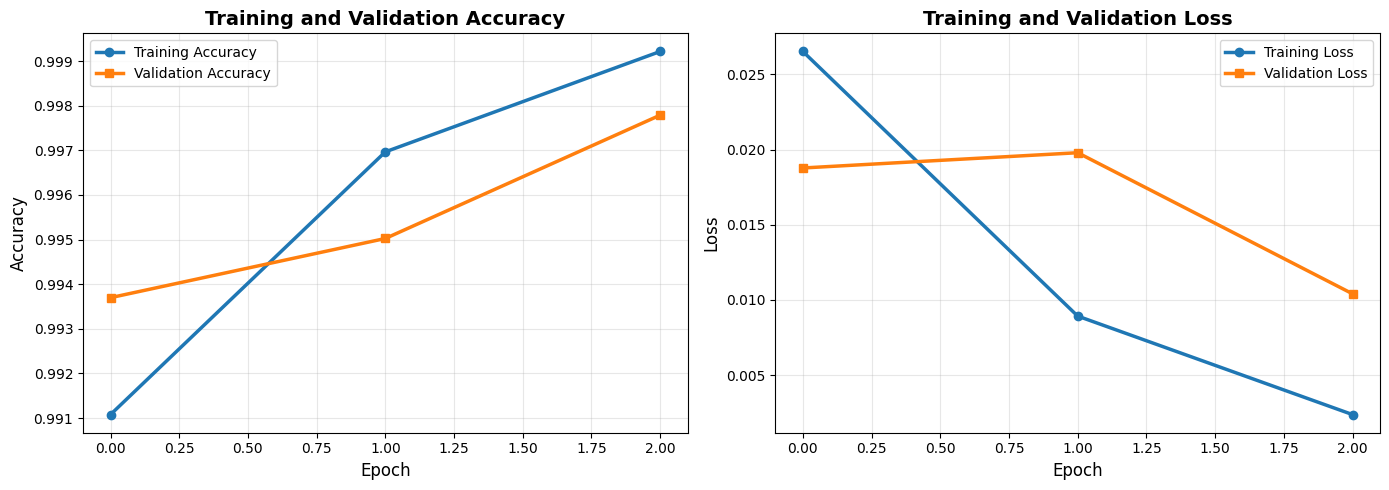

✓ Training history plot saved to results/sinbert_training_history.png


In [17]:
# Create results directory
os.makedirs('results', exist_ok=True)

# Plot training history
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2.5, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5, marker='s')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2.5, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, marker='s')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/sinbert_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved to results/sinbert_training_history.png")

## 18. Generate Predictions on Test Set

In [18]:
# Generate predictions
print("Generating predictions on test set...")
predictions = model.predict(test_inputs, batch_size=32, verbose=0)

# Get predicted labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Get prediction probabilities
probabilities = tf.nn.softmax(predictions.logits).numpy()
positive_class_probs = probabilities[:, 1]  # Probability for AI class

print(f"✓ Predictions generated for {len(predicted_labels)} samples")
print(f"\nPrediction distribution:")
print(f"  HUMAN: {np.sum(predicted_labels == 0)}")
print(f"  AI: {np.sum(predicted_labels == 1)}")

Generating predictions on test set...
✓ Predictions generated for 13046 samples

Prediction distribution:
  HUMAN: 7042
  AI: 6004


## 19. Confusion Matrix

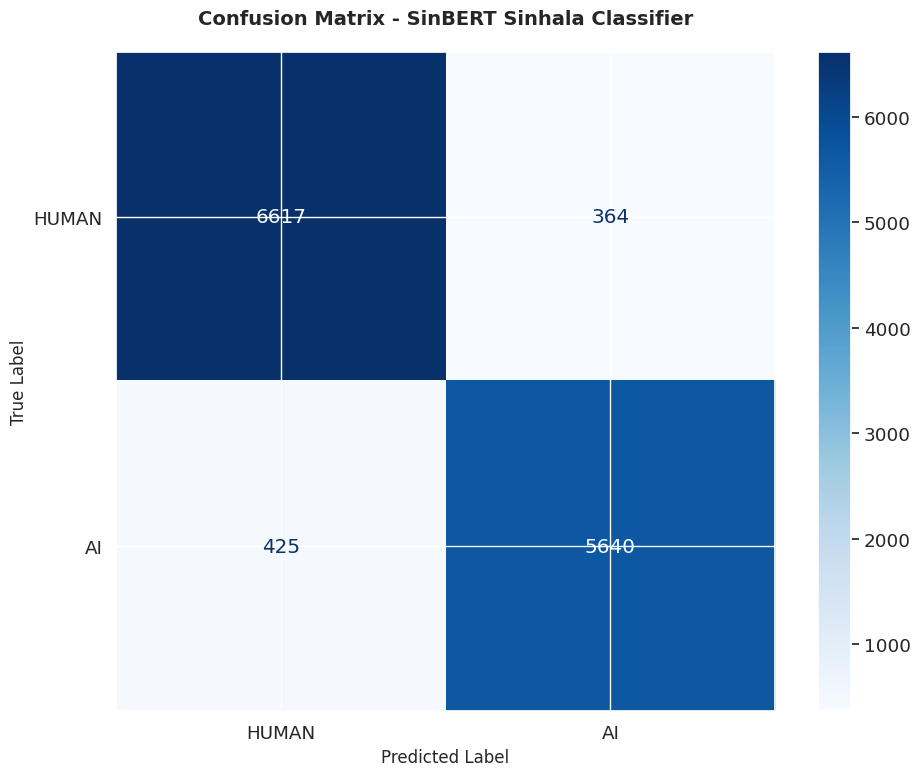

✓ Confusion matrix saved to results/sinbert_confusion_matrix.png

Confusion Matrix Analysis
True Negatives (HUMAN→HUMAN): 6617 (50.7%)
False Positives (HUMAN→AI):    364 (2.8%)
False Negatives (AI→HUMAN):    425 (3.3%)
True Positives (AI→AI):       5640 (43.2%)

Error Analysis:
  False Positive Rate: 0.0521 (5.21%)
  False Negative Rate: 0.0701 (7.01%)
  Misclassification Rate: 0.0605 (6.05%)
  ⚠️ Model tends to under-predict AI (more false negatives)


In [19]:
# Generate confusion matrix with detailed analysis
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['HUMAN', 'AI']
)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title('Confusion Matrix - SinBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('results/sinbert_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to results/sinbert_confusion_matrix.png")

# Print confusion matrix values with percentages
total = cm.sum()
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*60)
print("Confusion Matrix Analysis")
print("="*60)
print(f"True Negatives (HUMAN→HUMAN): {tn:4d} ({tn/total*100:.1f}%)")
print(f"False Positives (HUMAN→AI):   {fp:4d} ({fp/total*100:.1f}%)")
print(f"False Negatives (AI→HUMAN):   {fn:4d} ({fn/total*100:.1f}%)")
print(f"True Positives (AI→AI):       {tp:4d} ({tp/total*100:.1f}%)")
print("="*60)

# Calculate error rates
print(f"\nError Analysis:")
print(f"  False Positive Rate: {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.2f}%)")
print(f"  False Negative Rate: {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.2f}%)")
print(f"  Misclassification Rate: {(fp+fn)/total:.4f} ({(fp+fn)/total*100:.2f}%)")

# Identify most common error
if fp > fn:
    print(f"  ⚠️ Model tends to over-predict AI (more false positives)")
elif fn > fp:
    print(f"  ⚠️ Model tends to under-predict AI (more false negatives)")
else:
    print(f"  ✓ Balanced error distribution")

## 20. ROC Curve and AUC Score

AI index: 1, HUMAN index: 0
Probability range: [0.000006, 0.999995]
Mean prob when true=AI:    0.929762
Mean prob when true=HUMAN: 0.054514
Unique probability values: 8335


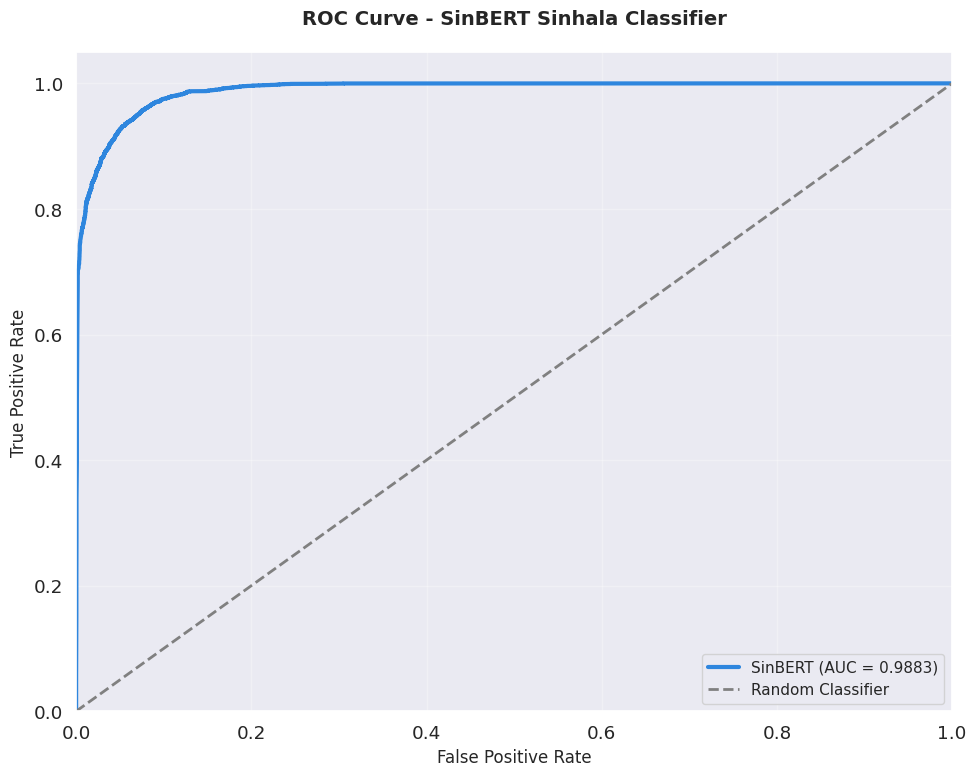


✓ ROC curve saved to results/sinbert_roc_curve.png

AUC Score: 0.9883

ROC Curve Diagnostics:
  Number of thresholds: 1277
  Threshold range: [0.000006, inf]
  Best threshold (Youden's J): 0.042222


In [20]:
# Calculate ROC curve and AUC with improved diagnostics
from sklearn.preprocessing import label_binarize

# Ensure probabilities are numpy arrays
if hasattr(positive_class_probs, 'numpy'):
    probs_np = positive_class_probs.numpy()
else:
    probs_np = np.array(positive_class_probs)

# Clip probabilities to valid range
probs_np = np.clip(probs_np, 0, 1)

# For binary classification, determine which class is AI
ai_class_idx = label_mapping['AI']  # Should be 1
human_class_idx = label_mapping['HUMAN']  # Should be 0

print(f"AI index: {ai_class_idx}, HUMAN index: {human_class_idx}")
print(f"Probability range: [{probs_np.min():.6f}, {probs_np.max():.6f}]")
print(f"Mean prob when true=AI:    {probs_np[test_labels == ai_class_idx].mean():.6f}")
print(f"Mean prob when true=HUMAN: {probs_np[test_labels == human_class_idx].mean():.6f}")
print(f"Unique probability values: {len(np.unique(probs_np))}")

# Calculate ROC curve using AI as positive class
fpr, tpr, thresholds = roc_curve(
    y_true=test_labels,
    y_score=probs_np,
    pos_label=ai_class_idx
)
auc_score = roc_auc_score(test_labels, probs_np)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'SinBERT (AUC = {auc_score:.4f})', linewidth=3, color='#2E86DE')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - SinBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig('results/sinbert_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ ROC curve saved to results/sinbert_roc_curve.png")
print(f"\nAUC Score: {auc_score:.4f}")

# Additional diagnostics
print(f"\nROC Curve Diagnostics:")
print(f"  Number of thresholds: {len(thresholds)}")
print(f"  Threshold range: [{thresholds.min():.6f}, {thresholds.max():.6f}]")
print(f"  Best threshold (Youden's J): {thresholds[np.argmax(tpr - fpr)]:.6f}")

## 21. Precision-Recall Curve

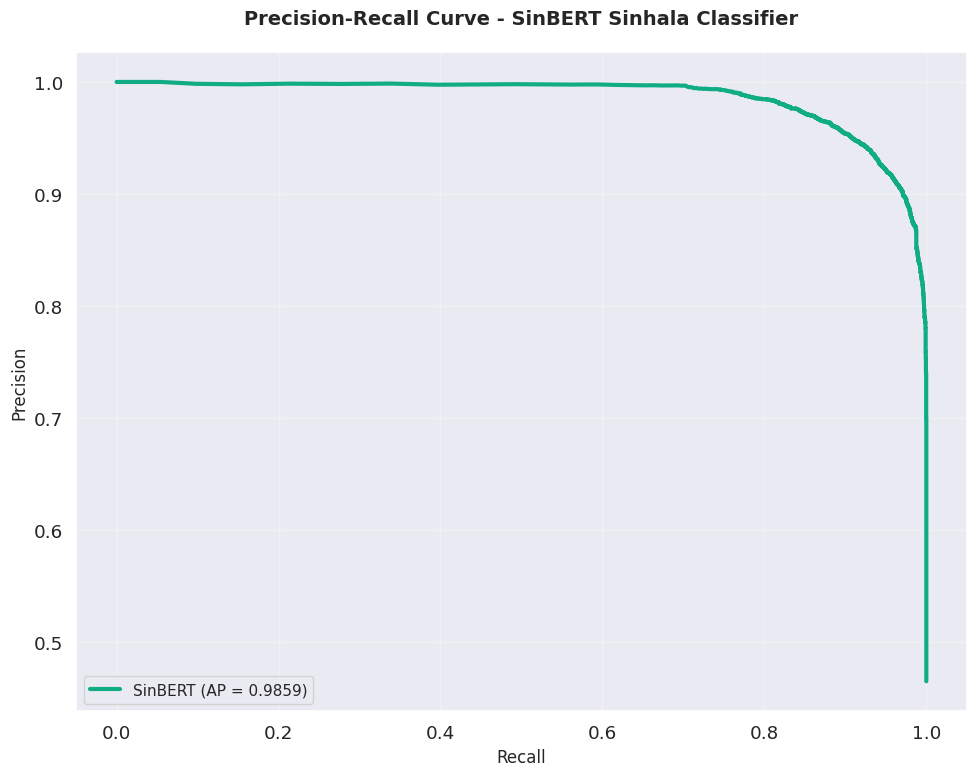

✓ Precision-Recall curve saved to results/sinbert_precision_recall_curve.png

Average Precision Score: 0.9859


In [21]:
# Calculate precision-recall curve
from sklearn.metrics import average_precision_score

precision, recall, pr_thresholds = precision_recall_curve(test_labels, positive_class_probs)
avg_precision = average_precision_score(test_labels, positive_class_probs)

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linewidth=3, color='#10AC84', label=f'SinBERT (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - SinBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/sinbert_precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Precision-Recall curve saved to results/sinbert_precision_recall_curve.png")
print(f"\nAverage Precision Score: {avg_precision:.4f}")

## 22. Classification Report

In [22]:
# Generate classification report
report = classification_report(
    test_labels,
    predicted_labels,
    target_names=['HUMAN', 'AI'],
    digits=4
)

print("\n" + "="*70)
print("CLASSIFICATION REPORT - TEST SET")
print("="*70)
print(report)
print("="*70)

# Save report to file
with open('results/sinbert_classification_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("CLASSIFICATION REPORT - SinBERT Sinhala Classifier\n")
    f.write("="*70 + "\n\n")
    f.write(report)
    f.write("\n" + "="*70)

print("\n✓ Classification report saved to results/sinbert_classification_report.txt")


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

       HUMAN     0.9396    0.9479    0.9437      6981
          AI     0.9394    0.9299    0.9346      6065

    accuracy                         0.9395     13046
   macro avg     0.9395    0.9389    0.9392     13046
weighted avg     0.9395    0.9395    0.9395     13046


✓ Classification report saved to results/sinbert_classification_report.txt


## 23. Detailed Performance Metrics

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Class-specific metrics
precision_per_class = precision_score(test_labels, predicted_labels, average=None)
recall_per_class = recall_score(test_labels, predicted_labels, average=None)
f1_per_class = f1_score(test_labels, predicted_labels, average=None)

# Create summary DataFrame
metrics_summary = pd.DataFrame({
    'Metric': [
        'Test Accuracy',
        'Test Loss',
        'AUC Score',
        'Average Precision',
        'Weighted Precision',
        'Weighted Recall',
        'Weighted F1-Score',
        'HUMAN - Precision',
        'HUMAN - Recall',
        'HUMAN - F1-Score',
        'AI - Precision',
        'AI - Recall',
        'AI - F1-Score'
    ],
    'Value': [
        f'{accuracy:.4f}',
        f'{test_loss:.4f}',
        f'{auc_score:.4f}',
        f'{avg_precision:.4f}',
        f'{precision:.4f}',
        f'{recall:.4f}',
        f'{f1:.4f}',
        f'{precision_per_class[0]:.4f}',
        f'{recall_per_class[0]:.4f}',
        f'{f1_per_class[0]:.4f}',
        f'{precision_per_class[1]:.4f}',
        f'{recall_per_class[1]:.4f}',
        f'{f1_per_class[1]:.4f}'
    ]
})

print("\n" + "="*60)
print("DETAILED PERFORMANCE METRICS")
print("="*60)
print(metrics_summary.to_string(index=False))
print("="*60)

# Save metrics
metrics_summary.to_csv('results/sinbert_performance_metrics.csv', index=False)
print("\n✓ Metrics saved to results/sinbert_performance_metrics.csv")


DETAILED PERFORMANCE METRICS
            Metric  Value
     Test Accuracy 0.9395
         Test Loss 0.3352
         AUC Score 0.9883
 Average Precision 0.9859
Weighted Precision 0.9395
   Weighted Recall 0.9395
 Weighted F1-Score 0.9395
 HUMAN - Precision 0.9396
    HUMAN - Recall 0.9479
  HUMAN - F1-Score 0.9437
    AI - Precision 0.9394
       AI - Recall 0.9299
     AI - F1-Score 0.9346

✓ Metrics saved to results/sinbert_performance_metrics.csv


## 24. Test Model on Sample Texts

In [24]:
def predict_text(text, model, tokenizer, max_length=256):
    """
    Predict if a given text is HUMAN or AI-generated.
    Returns prediction and confidence score.
    """
    # Preprocess text
    processed_text = preprocess_sinhala_text(text)

    # Tokenize
    encoding = tokenizer(
        [processed_text],
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    # Predict
    outputs = model(encoding)
    probs = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]

    predicted_label = np.argmax(probs)
    confidence = probs[predicted_label]

    return {
        'label': reverse_mapping[predicted_label],
        'confidence': float(confidence),
        'human_prob': float(probs[0]),
        'ai_prob': float(probs[1])
    }

# Test on sample texts from test set
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

sample_indices = np.random.choice(len(test_df), 5, replace=False)

correct_predictions = 0
for i, idx in enumerate(sample_indices, 1):
    text = test_df.iloc[idx]['text']
    true_label = test_df.iloc[idx]['label']

    result = predict_text(text, model, tokenizer, MAX_LENGTH)
    is_correct = result['label'] == true_label
    correct_predictions += is_correct

    status = "✓" if is_correct else "✗"
    print(f"\n{status} Sample {i}:")
    print(f"Text: {text[:100]}...")
    print(f"True Label: {true_label}")
    print(f"Predicted: {result['label']} (Confidence: {result['confidence']:.2%})")
    print(f"  HUMAN: {result['human_prob']:.2%} | AI: {result['ai_prob']:.2%}")
    print("-" * 70)

print(f"\nSample Accuracy: {correct_predictions}/{len(sample_indices)} ({correct_predictions/len(sample_indices)*100:.1f}%)")


SAMPLE PREDICTIONS

✓ Sample 1:
Text: අයි. එස් සටන්කාමින්ට අමෙරිකාවෙන් ගුවන් ප්‍රහාර

ඉරාකය සහ සිරියාව කේන්ද්‍ර කර ගනිමින් යළි හිස ඔසවමින්...
True Label: AI
Predicted: AI (Confidence: 100.00%)
  HUMAN: 0.00% | AI: 100.00%
----------------------------------------------------------------------

✓ Sample 2:
Text: а·ға¶ӯа·Ҡа·Җ а¶Ҫа·қа¶ҡа¶әа·ҡ а¶ а·’а¶ёа·Ҡа¶ҙа¶ұа·Ҡа·ға·’а¶ұа·Ҡа¶ңа·ҡ а¶ұа·Ҹа¶әа¶ҡа¶әа·Ҹа¶ңа·ҡ а¶…а¶«...
True Label: HUMAN
Predicted: HUMAN (Confidence: 99.97%)
  HUMAN: 99.97% | AI: 0.03%
----------------------------------------------------------------------

✓ Sample 3:
Text: ශ්‍රී ලංකාවේ දේශපාලන පසුබිම තුළ ඇතිව තිබෙන උණුසුම් තත්ත්වය සහ එහි ප්‍රතිඵල ගැන මෙම පුවත විස්තර කරයි....
True Label: AI
Predicted: AI (Confidence: 100.00%)
  HUMAN: 0.00% | AI: 100.00%
----------------------------------------------------------------------

✓ Sample 4:
Text: මහින්ද රාජපක්ෂ මහතා ජනාධිපති ධුරයෙන් ඉල්ලා අස්වීමෙන් පසු ඔහුගේ නම් කිරීම් පිළිබඳව ප්‍රශ්න නැගී ඇත. ප...
True Label: AI
Predicted: AI (C

## 25. Model Summary and Comparison

In [25]:
# Final summary
print("\n" + "="*70)
print("SinBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")
print("\nNote: SinBERT-large is specifically trained on Sinhala data, which may provide")
print("better performance compared to multilingual models like mBERT for Sinhala text.")


SinBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: NLPC-UOM/SinBERT-large
Parameters: 125,979,650
Max Sequence Length: 256

Dataset Sizes:
  Training: 77,788 samples
  Validation: 9,045 samples
  Test: 13,046 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.9395 (93.95%)
  Test Loss: 0.3352
  AUC Score: 0.9883
  Average Precision: 0.9859
  F1-Score: 0.9395

Model saved to: models/sinbert_sinhala_classifier/

✓ All tasks completed successfully!

Note: SinBERT-large is specifically trained on Sinhala data, which may provide
better performance compared to multilingual models like mBERT for Sinhala text.


## 26. Download Trained Model (Optional)

In [26]:
import shutil
from google.colab import files

# Define paths
folder_path = 'models/sinbert_sinhala_classifier'
output_filename = 'sinbert_sinhala_classifier'

# Zip the folder
shutil.make_archive(output_filename, 'zip', folder_path)
print(f"Zipped {folder_path} to {output_filename}.zip")

# Download the zip file
files.download(f"{output_filename}.zip")

Zipped models/sinbert_sinhala_classifier to sinbert_sinhala_classifier.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>